In [14]:
import numpy as np
import numba
import matplotlib
from matplotlib import pyplot as plt
from numba import cuda
import math
from time import time
from PIL import Image
import cv2

In [22]:
img = cv2.imread('Gosling.jpg')
img1 = cv2.imread('4.jpg')
img2 = cv2.imread('1.jpg')
img3 = cv2.imread('gis.jpg')

print("Images Properties")
print("For img:")
print("- Number of Pixels: " + str(img.size))
print("- Shape/Dimensions: " + str(img.shape))
print("For img1:")
print("- Number of Pixels: " + str(img1.size))
print("- Shape/Dimensions: " + str(img1.shape))
print("For img2:")
print("- Number of Pixels: " + str(img2.size))
print("- Shape/Dimensions: " + str(img2.shape))
print("For img3:")
print("- Number of Pixels: " + str(img3.size))
print("- Shape/Dimensions: " + str(img3.shape))

Images Properties
For img:
- Number of Pixels: 1199838
- Shape/Dimensions: (643, 622, 3)
For img1:
- Number of Pixels: 847476
- Shape/Dimensions: (399, 708, 3)
For img2:
- Number of Pixels: 1620000
- Shape/Dimensions: (600, 900, 3)
For img3:
- Number of Pixels: 3396600
- Shape/Dimensions: (850, 1332, 3)


In [42]:
saved = "1.jpg"
saved = "4.jpg"
saved = "Gosling.jpg"
saved = "gis.jpg"

img = Image.open("1.jpg")
width = img.size[0]  # Определяем ширину
height = img.size[1]  # Определяем высоту
pix = img.load()  # Выгружаем значения пикселей

img1 = Image.open("4.jpg")
width = img1.size[0]  # Определяем ширину
height = img1.size[1]  # Определяем высоту
pix1 = img1.load()  # Выгружаем значения пикселей

img2 = Image.open("Gosling.jpg")
width = img2.size[0]  # Определяем ширину
height = img2.size[1]  # Определяем высоту
pix2 = img2.load()  # Выгружаем значения пикселей

img3 = Image.open("gis.jpg")
width = img3.size[0]  # Определяем ширину
height = img3.size[1]  # Определяем высоту
pix3 = img3.load()  # Выгружаем значения пикселей
print("1:" + str(img.load))
print("4:" + str(img.load))
print("Gosling:" + str(img.load))
print("gis:" + str(img.load))


1:<bound method ImageFile.load of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=900x600 at 0x7FB2208357F0>>
4:<bound method ImageFile.load of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=900x600 at 0x7FB2208357F0>>
Gosling:<bound method ImageFile.load of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=900x600 at 0x7FB2208357F0>>
gis:<bound method ImageFile.load of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=900x600 at 0x7FB2208357F0>>


In [16]:
def salt_and_pepper_add(image, prob):
  rnd = np.random.rand(image.shape[0], image.shape[1])
  noisy = image.copy()
  noisy[rnd < prob] = 0
  noisy[rnd > 1 - prob] = 255
  return noisy

In [17]:
def median_filter(a):
  b = a.copy()
  start = time()
  for i in range(2, len(a)-1):
    for j in range(2, len(a[i])-1):
      t=[0, 0, 0, 0, 0, 0, 0, 0, 0]
      t[0], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8] = a[i-1][j-1], a[i-1][j], a[i-1][j+1], a[i][j-1], a[i][j], a[i][j+1], a[i+1][j-1], a[i+1][j], a[i+1][j+1]
      for k in range(8):
        for l in range(8-k):
          if t[l]>t[l+1]:
            t[l], t[l+1] = t[l+1], t[l]
      b[i][j]=t[(int)(len(t)/2)]
  return b, time()-start

In [18]:
@cuda.jit
def gpu_median_filter(a, b):
  i, j = cuda.grid(2)
  t=cuda.local.array(shape=9, dtype=numba.int64)
  t[0], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8] = a[i-1][j-1], a[i-1][j], a[i-1][j+1], a[i][j-1], a[i][j], a[i][j+1], a[i+1][j-1], a[i+1][j], a[i+1][j+1]
  for k in range(8):
    for l in range(8-k):
      if t[l]>t[l+1]:
        t[l], t[l+1] = t[l+1], t[l]
  b[i][j]=t[(int)(len(t)/2)]
  

In [19]:
def prepare_and_exec_gpu(a):
  b = a.copy()
  tread_number_block = 32

  a_global = cuda.to_device(a)
  b_global = cuda.to_device(b)
    
  threadsperblock = (tread_number_block, tread_number_block)
  blockspergrid_x = int(math.ceil(a.shape[0] / threadsperblock[1]))
  blockspergrid_y = int(math.ceil(b.shape[1] / threadsperblock[0]))
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  start = time()
  gpu_median_filter[blockspergrid, threadsperblock](a_global, b_global)
  return b_global.copy_to_host(), time()-start 


In [20]:
def experiment(img_name, need_draw):
  im=(Image.open(img_name)).convert('L')
  if need_draw==True:
    display(im)
  img = np.array(im)

  img = salt_and_pepper_add(img, 0.09)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img)))

  img2, ctime = median_filter(img)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img2)))

  img2, gtime = prepare_and_exec_gpu(img)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img2)))
  
  n=len(img)*len(img[0])
  print('Количество элементов =', n)
  print('Время на CPU =', ctime)
  print('Время на GPU =', gtime)
  print('Ускорение =', ctime/gtime)
  print()
  return ctime/gtime, n


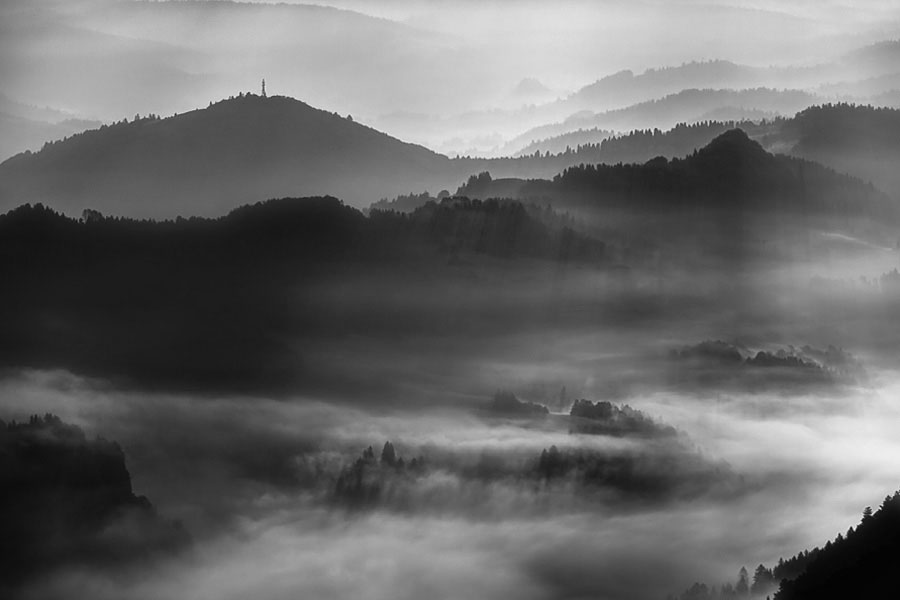

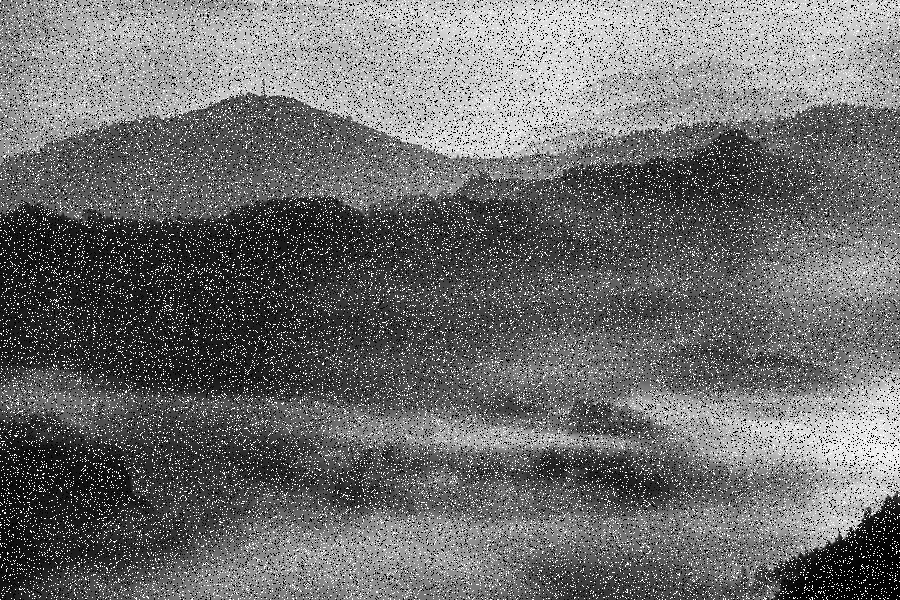

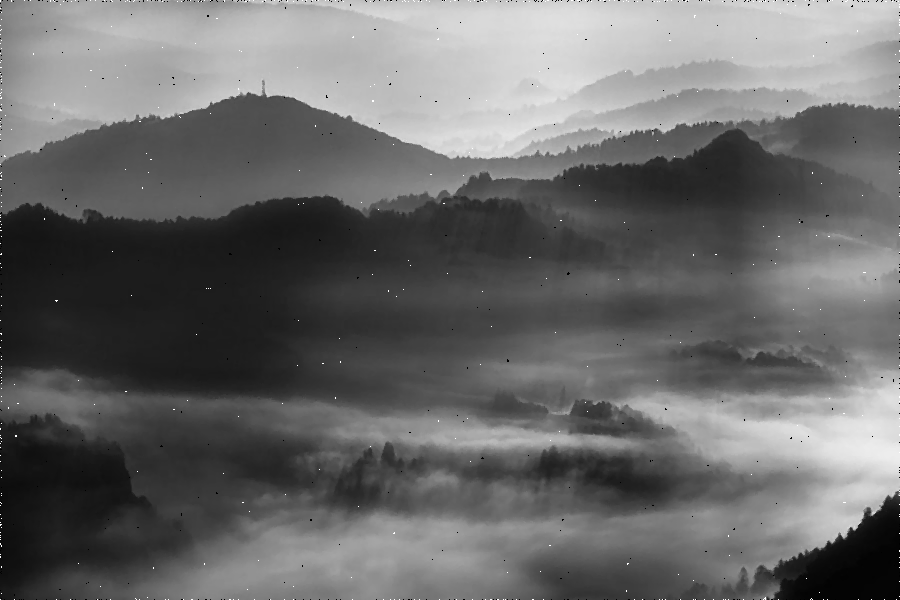

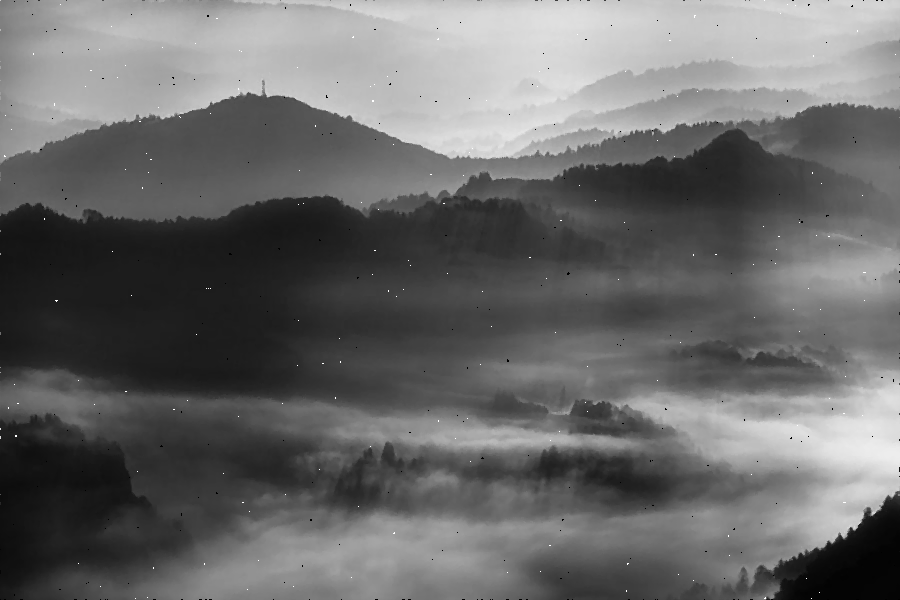

Количество элементов = 540000
Время на CPU = 5.614957809448242
Время на GPU = 0.3462069034576416
Ускорение = 16.218503309351924



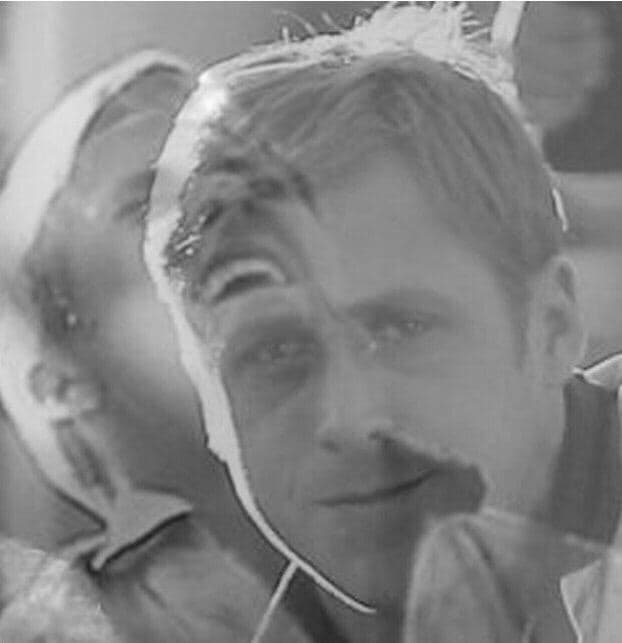

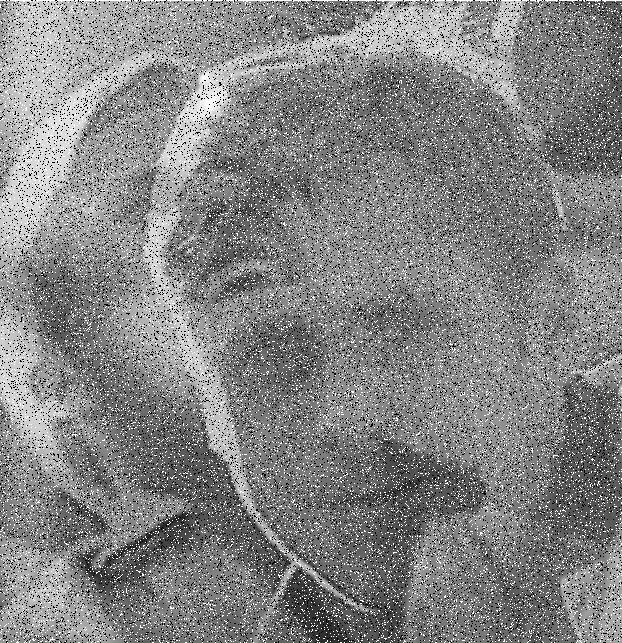

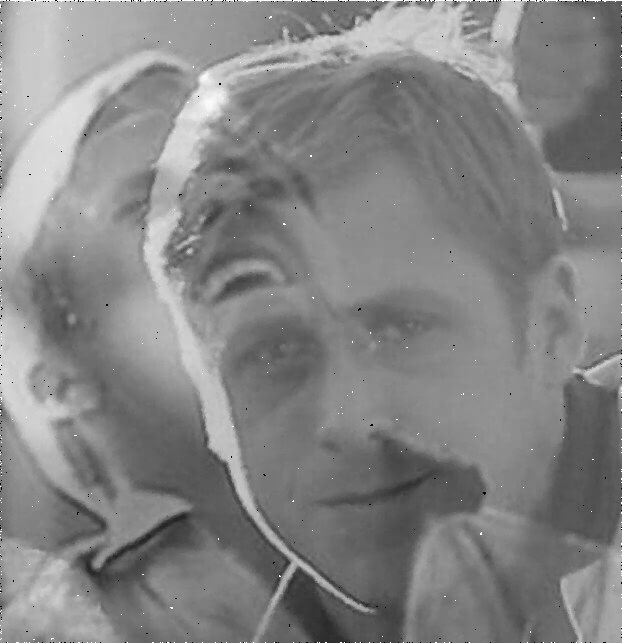

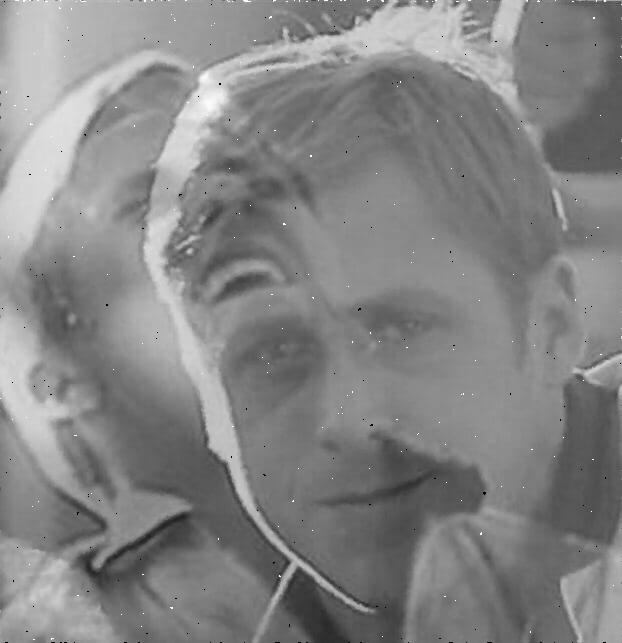

Количество элементов = 399946
Время на CPU = 4.259243726730347
Время на GPU = 0.000888824462890625
Ускорение = 4791.996512875537



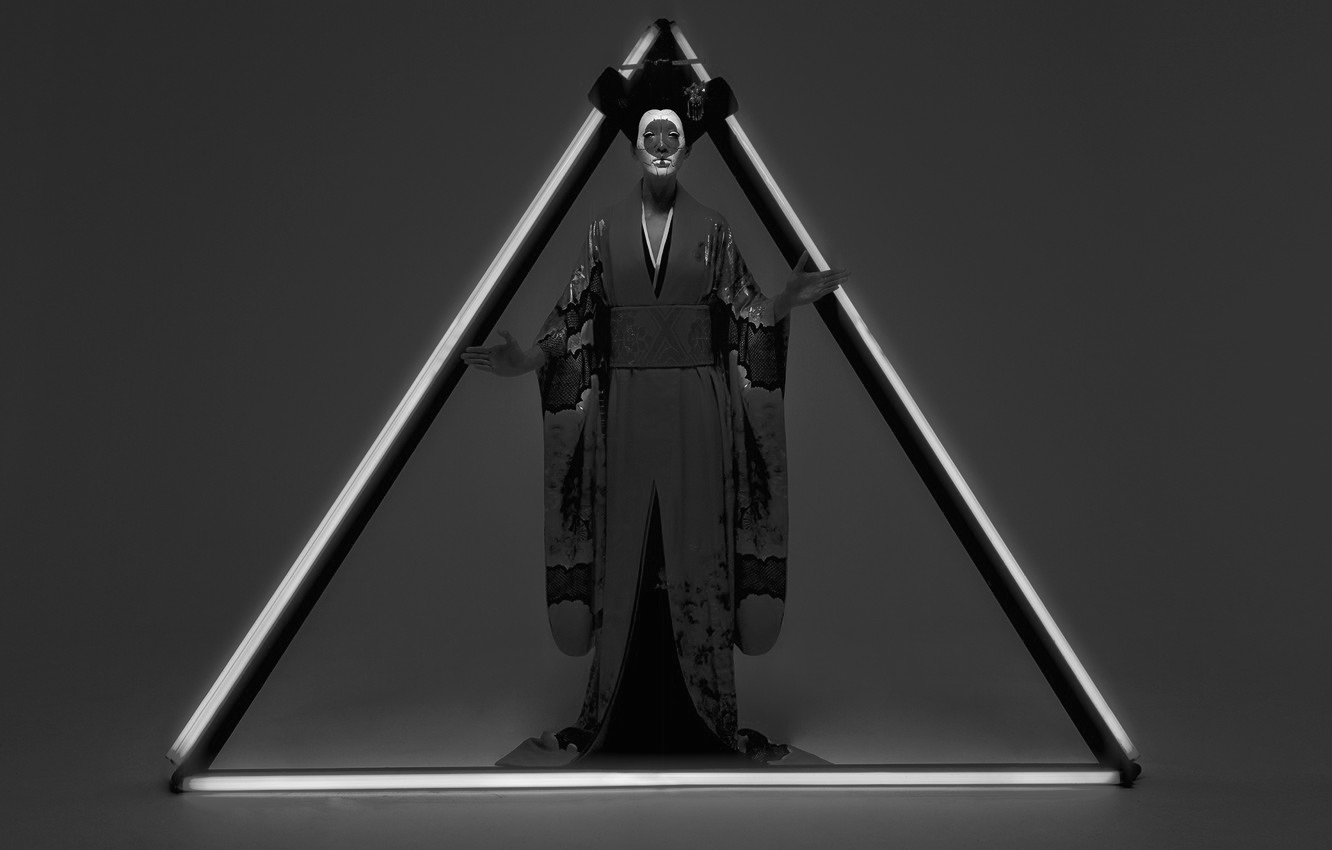

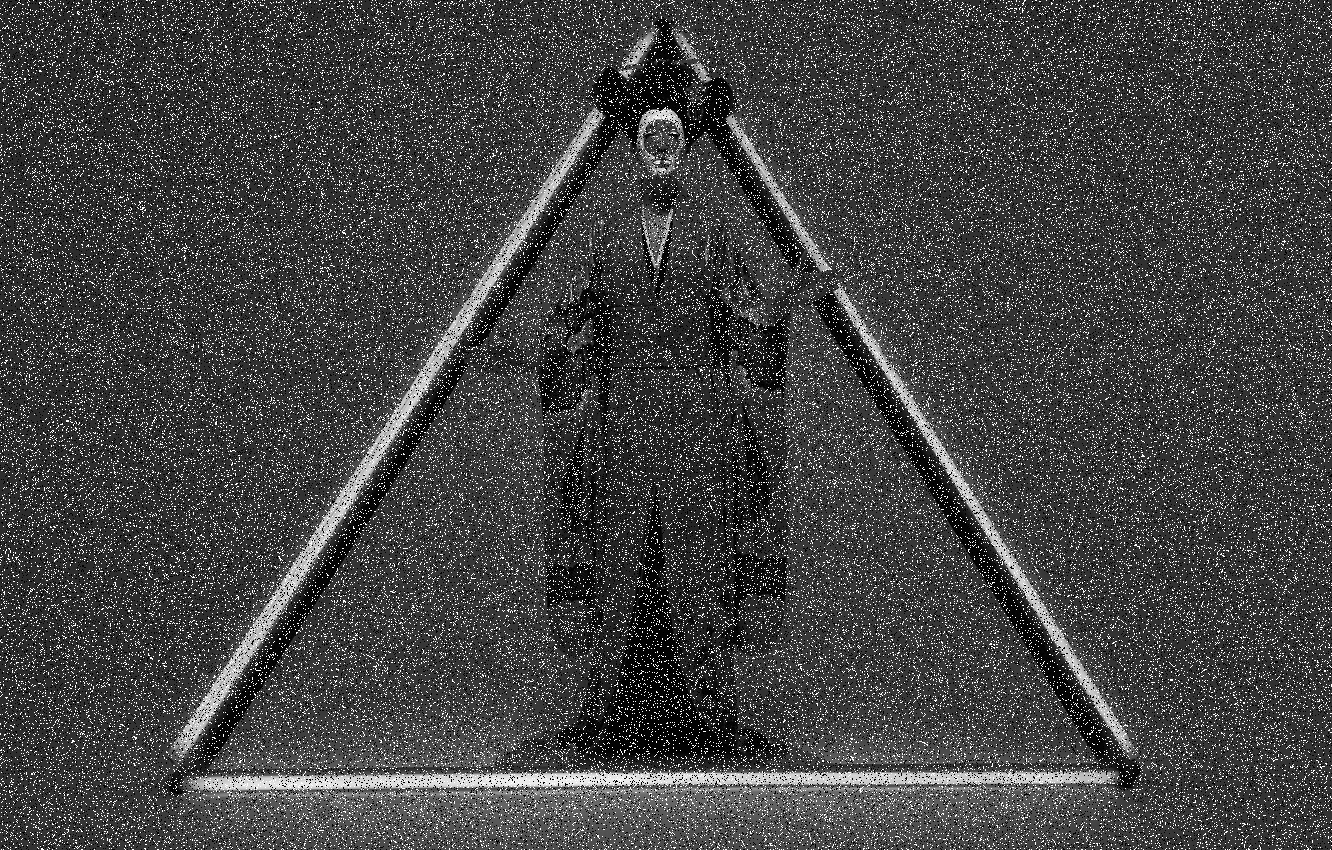

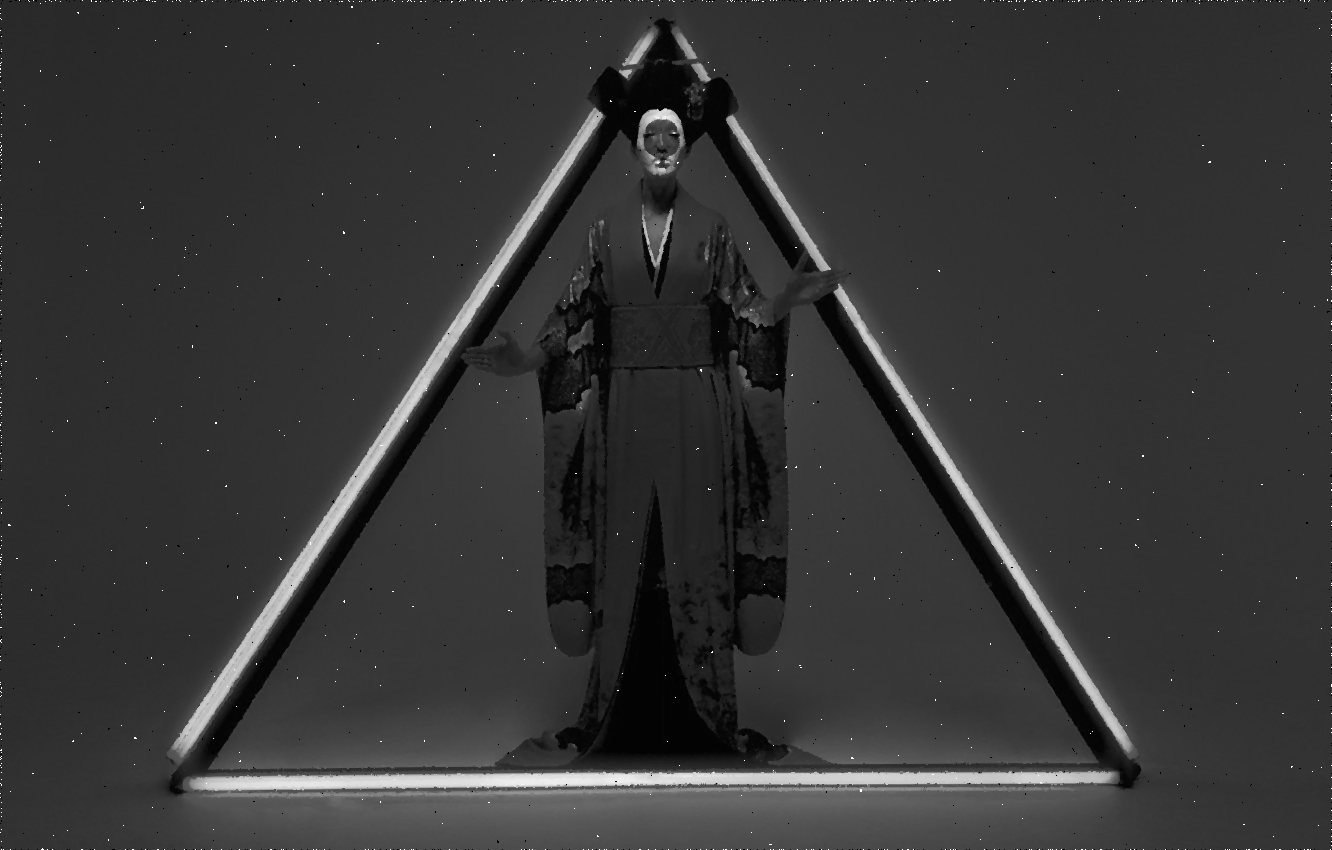

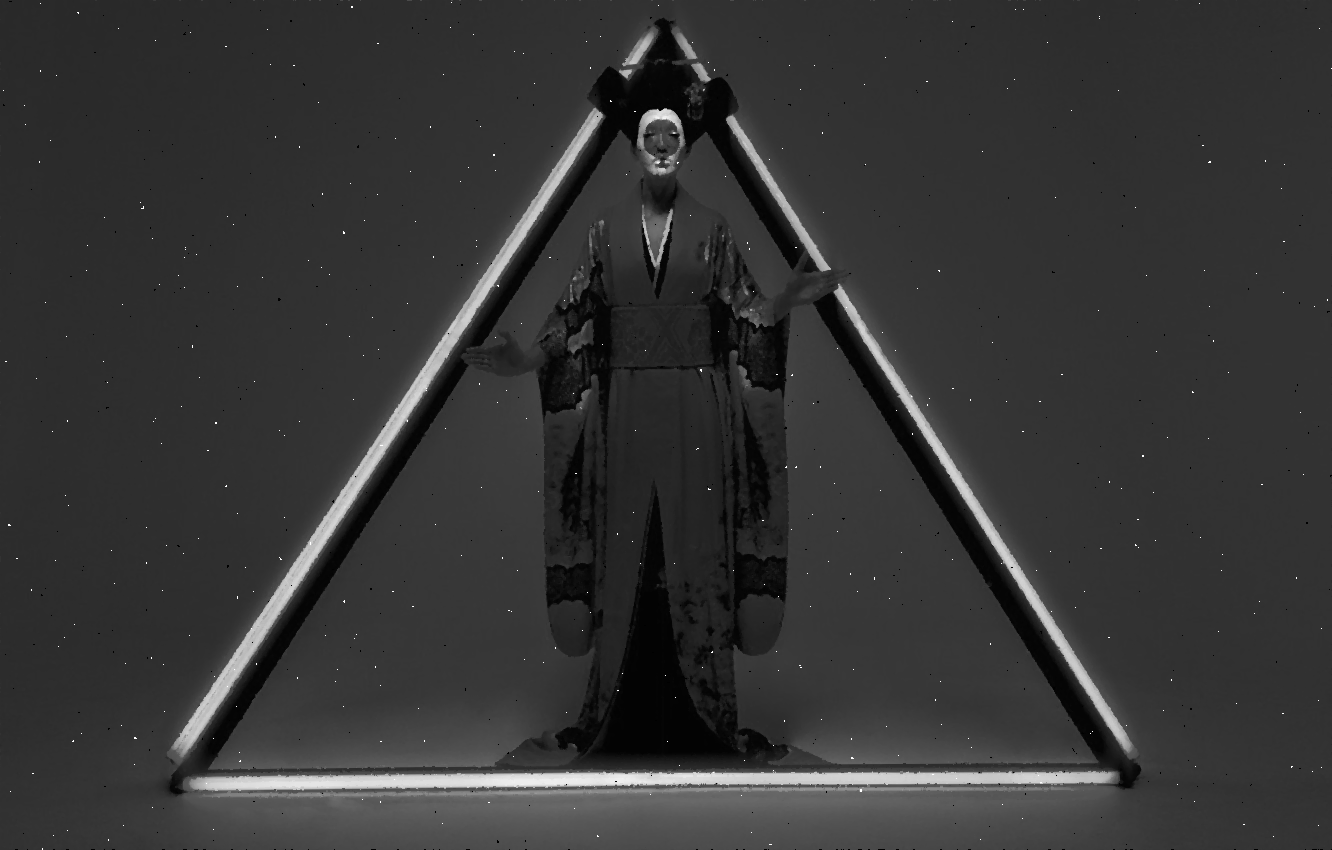

Количество элементов = 1132200
Время на CPU = 11.620811700820923
Время на GPU = 0.0014224052429199219
Ускорение = 8169.831880657057



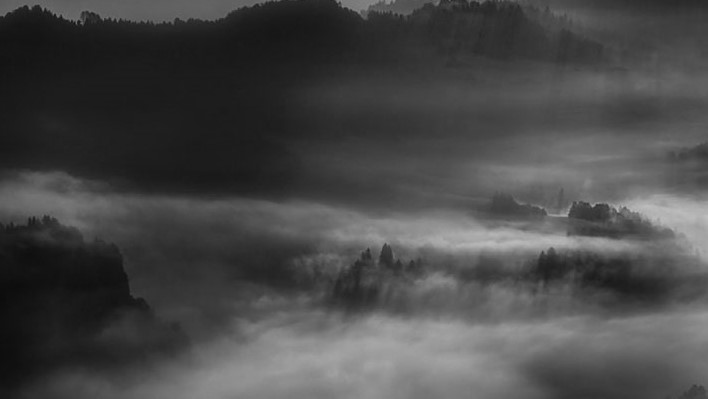

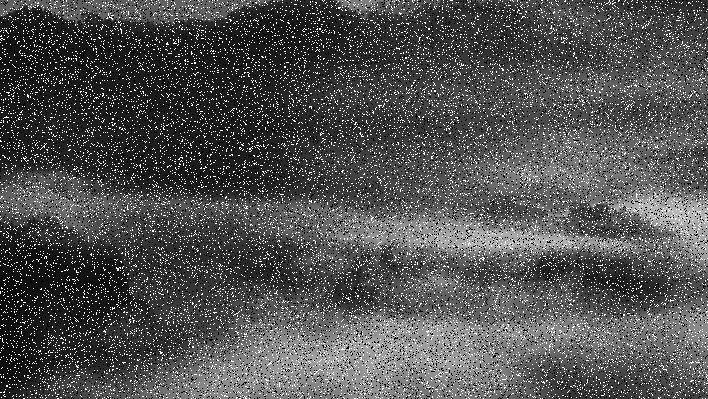

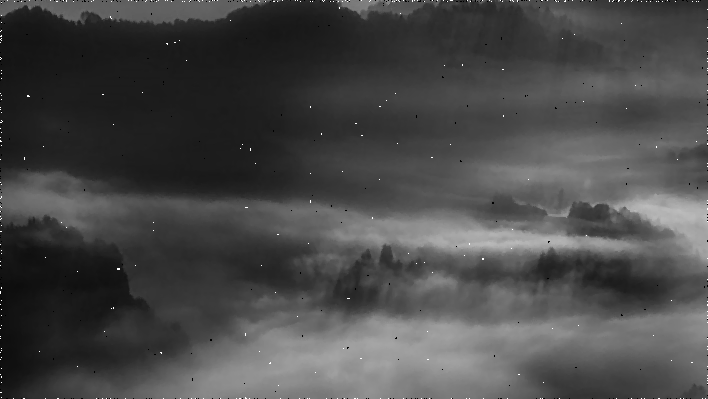

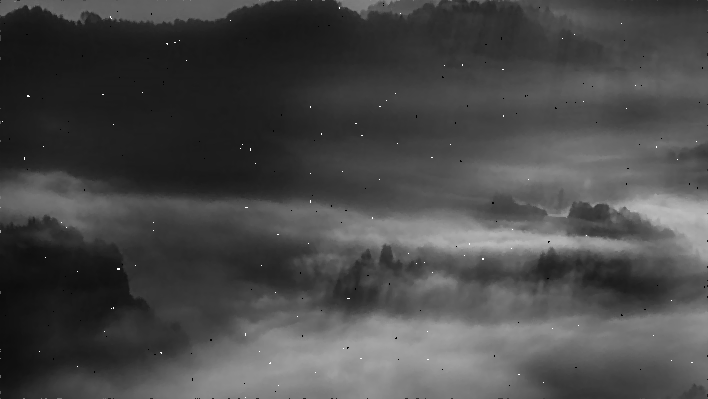

Количество элементов = 282492
Время на CPU = 3.006042957305908
Время на GPU = 0.0007579326629638672
Ускорение = 3966.108210128971



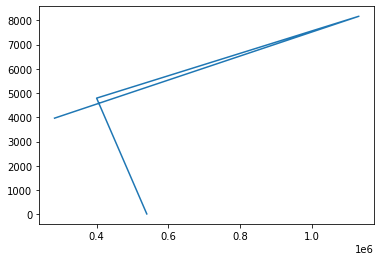

In [21]:
a1, n1 = experiment('1.jpg', True)
a2, n2 = experiment('Gosling.jpg', True)
a3, n3 = experiment('gis.jpg', True)
a4, n4 = experiment('4.jpg', True)

plt.plot([n1, n2, n3, n4], [a1, a2, a3, a4])
plt.show()